## Постановка задачи
Разберем архитектуру Inception для решения задач распознавания изображений. Построим эту нейросеть для анализа исходных изображений.

Используя обученную модель, построим предсказания. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

![](inception.png)

### Подключение библиотек

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from skimage import io
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Используемые функции

In [2]:
filesDir = "train_images_small"
batch_size = 50
image_x = 299 # 525
image_y = 299 # 350
image_ch = 3 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        img = image.load_img(os.path.join(filesDir, file),
                     target_size=(image_y, image_x))
        img = image.img_to_array(img)
        x[j] = np.expand_dims(img, axis=0)
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
8572                                                 NaN  619232f.jpg  Fish
20308  1043050 308 1043359 4 1043364 4 1043376 17 104...  ea17711.jpg  Fish
9800                                                 NaN  6ef9413.jpg  Fish
17104                                                NaN  c55412b.jpg  Fish
1716   11463 733 12863 733 14263 733 15663 733 17063 ...  136f59b.jpg  Fish


### Inception v3
Подключим обученную нейросеть (89 Мб) и построим поверх классификатора новые слои. Используем результат работы обученной нейросети как входной слой для обучения последнего слоя, нашего классификатора.

In [6]:
inc_model = InceptionV3(weights='imagenet', include_top=False,
                       input_shape=(image_y, image_x, image_ch))

W0325 12:05:10.745032  2724 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0325 12:05:12.887155  2724 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [7]:
inc_model.compile(optimizer="sgd", loss="mean_absolute_error")
inc_model_output = inc_model.predict_generator(load_data(train, 1),
                        steps=len(train), verbose=1)

4436/4436 [==============================] - 3404s 767ms/step


In [12]:
top_model = Sequential([
    Flatten(input_shape=inc_model_output.shape[1:]),
    BatchNormalization(),
    Dropout(0.5),
    Activation("softmax"),
    Dense(1)
])
top_model.compile(optimizer=optimizers.Nadam(lr=0.02),
                 loss="mean_absolute_error")

### Обучение модели

In [13]:
top_model.fit(inc_model_output, load_y(train), epochs=100)

Epoch 1/100
4436/4436 [==============================] - 86s 19ms/step - loss: 0.4954
Epoch 2/100
4436/4436 [==============================] - 66s 15ms/step - loss: 0.4887
Epoch 3/100
4436/4436 [==============================] - 62s 14ms/step - loss: 0.4679
Epoch 4/100
4436/4436 [==============================] - 64s 14ms/step - loss: 0.4676
Epoch 5/100
4436/4436 [==============================] - 74s 17ms/step - loss: 0.4631
Epoch 6/100
4436/4436 [==============================] - 65s 15ms/step - loss: 0.4632
Epoch 7/100
4436/4436 [==============================] - 69s 16ms/step - loss: 0.4553
Epoch 8/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4580
Epoch 9/100
4436/4436 [==============================] - 65s 15ms/step - loss: 0.4508
Epoch 10/100
4436/4436 [==============================] - 66s 15ms/step - loss: 0.4532
Epoch 11/100
4436/4436 [==============================] - 62s 14ms/step - loss: 0.4510
Epoch 12/100
4436/4436 [============================

4436/4436 [==============================] - 63s 14ms/step - loss: 0.4172
Epoch 96/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4115
Epoch 97/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4110
Epoch 98/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4108
Epoch 99/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4034
Epoch 100/100
4436/4436 [==============================] - 63s 14ms/step - loss: 0.4118


In [14]:
model = Model(inputs=inc_model.input,
             outputs=top_model(inc_model.output))
model.compile(optimizer="adam", loss="mean_absolute_error")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Построение предсказания

In [15]:
prediction = model.predict_generator(load_data(test, 1),
                        steps=len(test), verbose=1)

1110/1110 [==============================] - 752s 678ms/step


In [16]:
prediction = np.transpose(prediction)

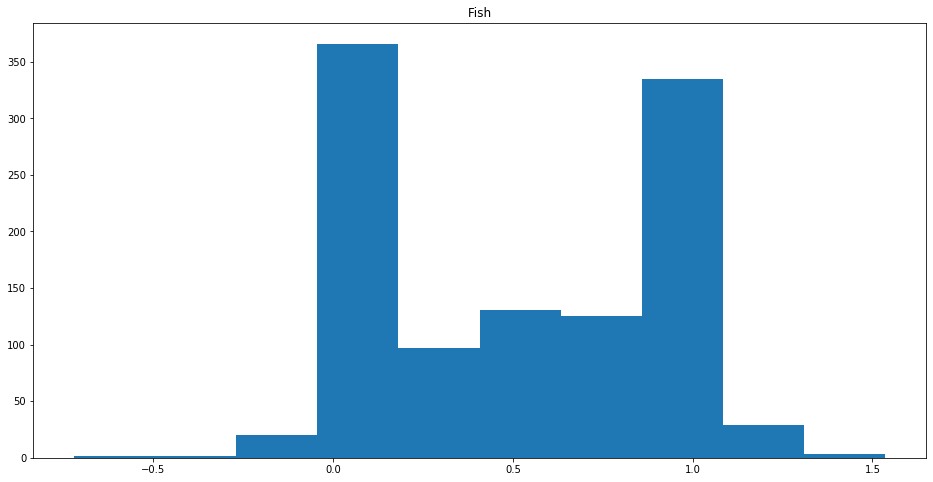

In [17]:
draw_prediction(prediction)

In [29]:
test["target"] = (prediction[0]>=1.1).astype("int8")
print (test[test["target"]>0][["EncodedPixels","target"]])

                                           EncodedPixels  target
22032  24699 501 26099 501 27499 501 28899 501 30299 ...       1
2116   59303 487 60703 487 62103 487 63503 487 64903 ...       1
18288  51802 628 53202 628 54602 628 56002 628 57402 ...       1
15824                                                NaN       1
13144  873 353 2273 353 3673 353 5073 353 6473 353 78...       1
19940  20167 462 21567 462 22967 462 24367 462 25767 ...       1
14016                                                NaN       1
16068                                                NaN       1
11036                                                NaN       1
8668   7406 982 8806 982 10206 982 11606 982 13006 98...       1
19440                                                NaN       1
10148                                                NaN       1
2716   460433 8 460457 16 461833 8 461857 16 463233 8...       1
15888                                                NaN       1
9548   17422 221 18822 22

### Расчет точности предсказания
Нет облаков - 0.5, MLP - 0.3, CONV/VGG16 - 0.48, AlexNex - 0.21

In [30]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, Inception v3:", round(dice.mean(), 3))

Keras, Inception v3: 0.496
